#Install Packages and Retrieve Data

In [0]:
# install stuff
%%capture
!pip install -U gensim
!pip install urllib2

In [2]:
# check gensim version
import gensim
gensim.__version__

'3.8.1'

In [0]:
# import stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from statistics import mean 

from gensim import corpora
from gensim.models import LsiModel, KeyedVectors
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.nmf import Nmf

import sklearn.model_selection as ms
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


from datetime import *
from operator import itemgetter

In [0]:
%%capture
!wget https://cis.upenn.edu/~cis545/data/reviews.dict
!wget https://cis.upenn.edu/~cis545/data/train_reviews.mm
!wget https://cis.upenn.edu/~cis545/data/train_times.npy

#Load Data and Define All Functions Needed

In [0]:
#reviews
reviews_dict = corpora.Dictionary.load("reviews.dict")
reviews_bow = corpora.MmCorpus('train_reviews.mm')

#review times
reviews_times  = np.load('train_times.npy')
reviews_times.shape = (len(reviews_bow),1)

#star ratings array
y = np.vstack((np.repeat(1, 4000), np.repeat(2, 4000), np.repeat(3, 4000), np.repeat(4, 4000), np.repeat(5, 4000)))
y = np.repeat(y, 5)

#get docs from corpus at specified indicies
def lookup_docs(corpus, indices):
    temp_list = []
    #return document at index
    for i, document in enumerate(corpus):
        if i in indices:
          temp_list.append(document)
    return temp_list

#translate the retreived docs using the dictionary
def translate_review(review, reviews_dict):
    temp_string = ""
    i = 0
    for index, count in review:
      i = 0
      while i < count:
        temp_string += reviews_dict[index] + " "
        i += 1
    return temp_string

#get the indicies for star ratings
def get_indices_for_star_rating(rating):
    star_indicie_list = []
    for index, value in enumerate(y):
        if value == rating:
            star_indicie_list.append(index)
    return star_indicie_list


#Convert Times to Date Time Format

In [0]:
def convert_times(reviews_times):
    converted_time = []
    for time in reviews_times:
        converted_time.append(datetime.fromtimestamp(time))

    converted_time = pd.Series(converted_time)
    return converted_time

converted_times = convert_times(reviews_times)

In [0]:
def days_before(time_item, offset):
    offset_time = time_item - timedelta(offset)
    return offset_time   

#Which years had the most number of reviews?

The dataset shows that there is an upward tick in the reviews from 2010 onwards.
Meaning that the data is heavily skewed towards the later half of the decade. This makes sense as Amazon really started taking off after 2008.

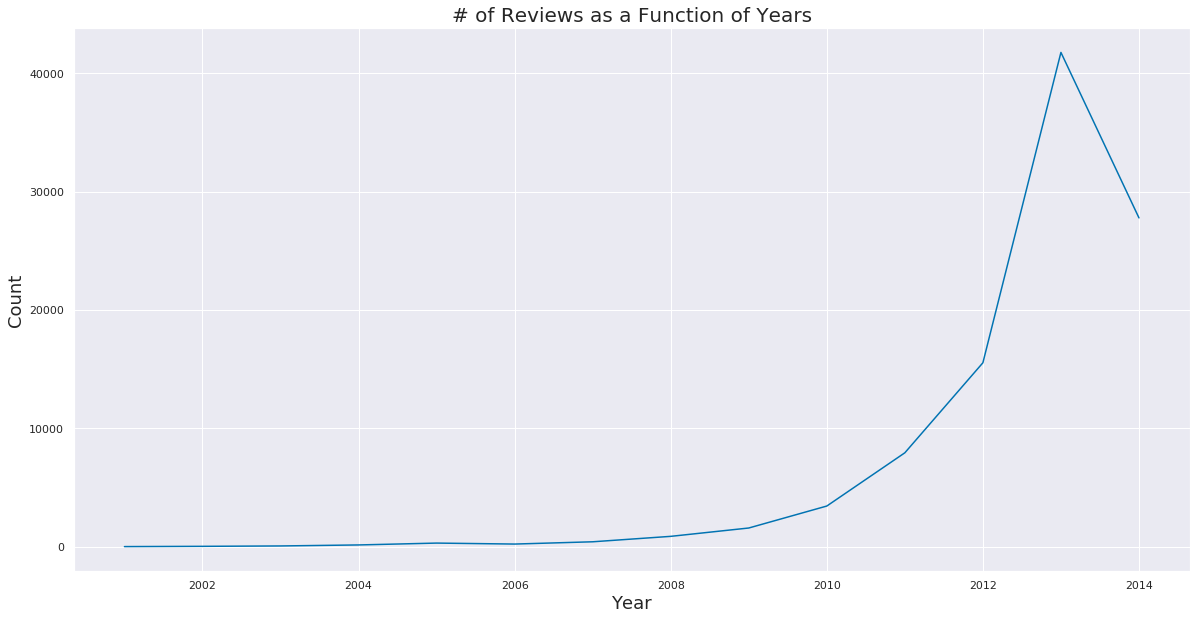

In [8]:
#capture the years from converted times
years = converted_times.apply(lambda x: x.year)

#count the number of reviews per year
counted_years = years.value_counts()
counted_years = counted_years.sort_index()
#print(counted_years)

#plotting histogram of reviews per year
sns.set(palette='colorblind',style='darkgrid')
fig = plt.figure(figsize=(20,10))
ax = plt.axes()
plt.title("# of Reviews as a Function of Years", fontsize = 20)
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Count", fontsize = 18)
plt.plot(counted_years)

#Distribution of Stars vs. Year
If we look at the star ratings vs. each year there is a trend towards higher and more evenly dispersed ratings after 2008. 2013 seems to have the most evenly distributed count of ratings across the 4 ratings

Text(0, 0.5, 'Count')

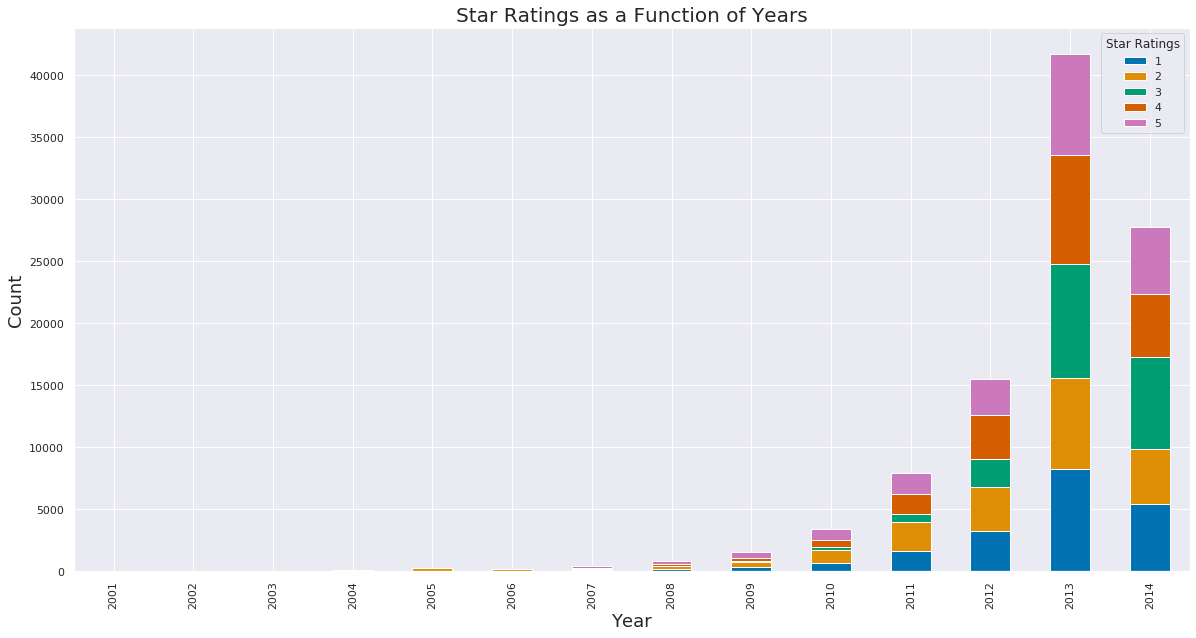

In [9]:
years = converted_times.apply(lambda x: x.year)
months = converted_times.apply(lambda x: x.month)
day = converted_times.apply(lambda x: x.day)
weekdays = converted_times.apply(lambda x: x.weekday())

year = years.to_list()
month = months.to_list()
day = day.to_list()
weekdays = weekdays.to_list()

df = pd.DataFrame(data = {'Year':years, 'Month':months, 'Star Ratings':y, 'Weekday':weekdays})
sns.set(palette='colorblind',style='darkgrid')
df_plot = df.groupby(['Year', 'Star Ratings'] ).size().reset_index().pivot(columns='Star Ratings', index='Year', values=0).plot(kind='bar', stacked=True, figsize=(20,10))
plt.title("Star Ratings as a Function of Years", fontsize = 20)
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Count", fontsize = 18)

#Distribution of Stars vs. Month
If we look at the star ratings vs. each month we can see that there is an interesting downward trend towards the middle half of the year. The first two months and the last two months seem to have the most ratings 

Text(0, 0.5, 'Count')

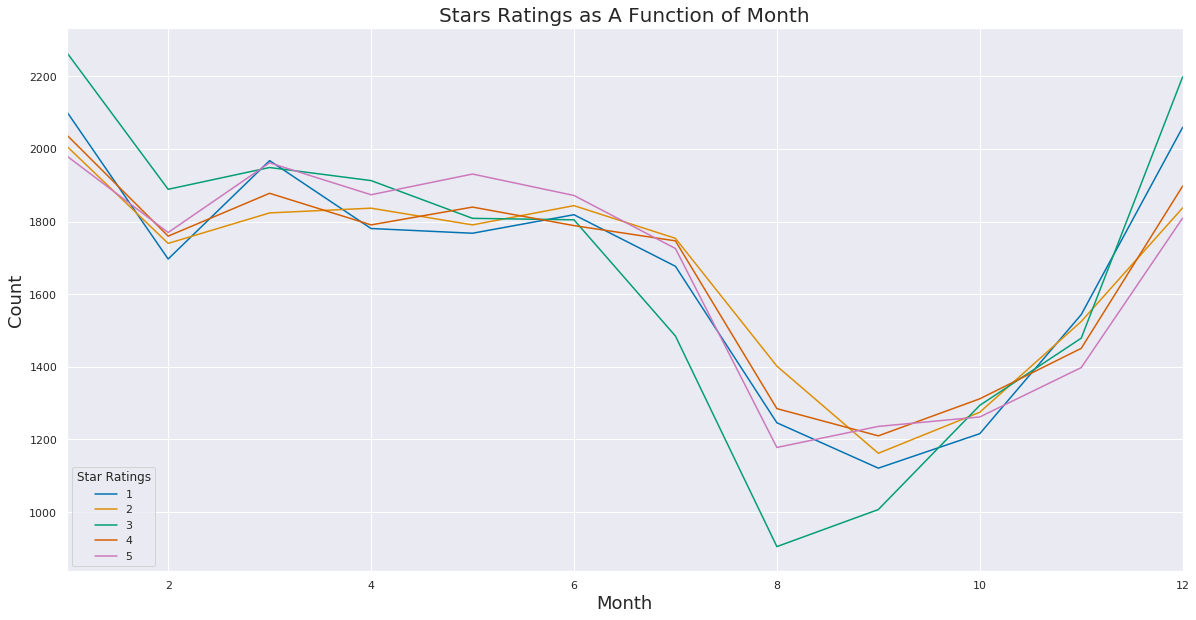

In [10]:
years = converted_times.apply(lambda x: x.year)
months = converted_times.apply(lambda x: x.month)
day = converted_times.apply(lambda x: x.day)
weekdays = converted_times.apply(lambda x: x.weekday())

year = years.to_list()
month = months.to_list()
day = day.to_list()
weekdays = weekdays.to_list()
df = pd.DataFrame(data = {'Year':years, 'Month':months, 'Star Ratings':y, 'Weekday':weekdays})

sns.set(palette='colorblind',style='darkgrid')
fig, ax = plt.subplots(figsize=(20,10))
df=df.groupby(['Month','Star Ratings']).count()['Year'].unstack().plot(ax=ax)
plt.title("Stars Ratings as A Function of Month", fontsize = 20)
plt.xlabel("Month", fontsize = 18)
plt.ylabel("Count", fontsize = 18)

#How Many Reivews Were Recorded Each Day of The Week?
Looks like the dataset is mostly uniform across the days of the week. But there 
is a huge spike towards the end of the week. Meaning there are a ton of reviews at the end of the week, which makes sense. People tend to shop on Saturdays and Sundays.


Text(0, 0.5, 'Count of Reviews')

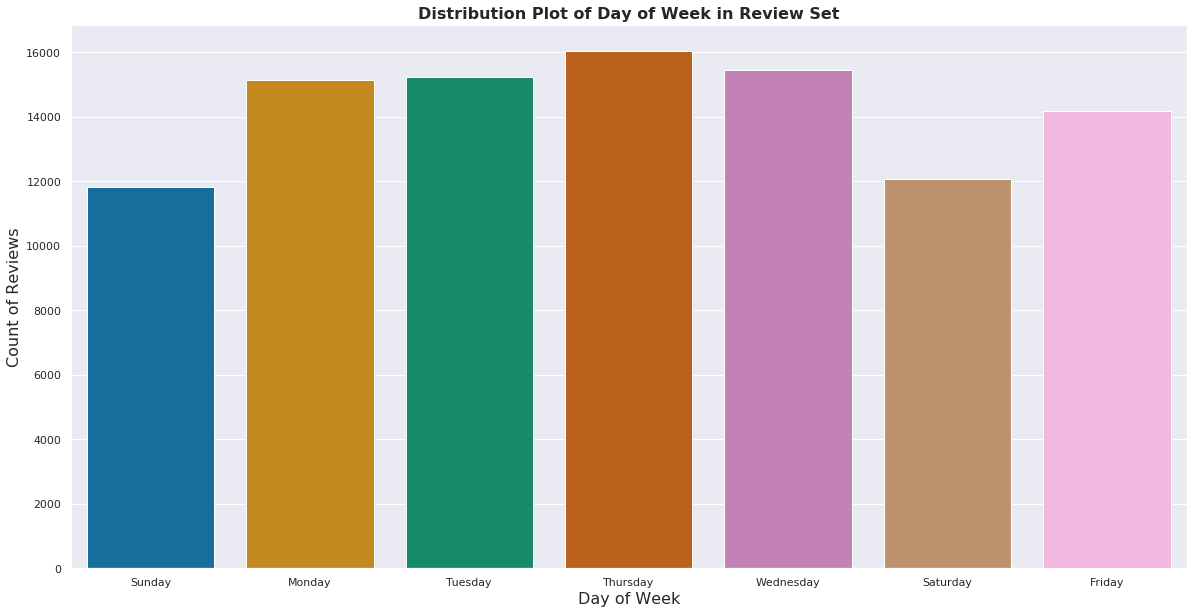

In [11]:
df = pd.DataFrame(data = {'Year':years, 'Month':months, 'Star Ratings':y, 'Weekday':weekdays})
df['Day of Week'] = converted_times.dt.day_name().sort_index()
#df=df.groupby(['Weekday']).count()['Star Ratings']

#display(df)

sns.set(palette='colorblind',style='darkgrid')
fig, ax = plt.subplots(figsize=(20,10))

sns.countplot(x='Day of Week',
              data=df)
              
plt.title('Distribution Plot of Day of Week in Review Set', weight='bold', fontsize=16)
plt.xlabel('Day of Week', fontsize = 16)
plt.ylabel('Count of Reviews', fontsize = 16)




#Does Day of Week Affect Review Ratings?
But if we take a closer look within each day and how the ratings are counted, is there any difference? Apparently there's not much of a difference in how generous people are with their ratings across the days

Text(0, 0.5, 'Number of Ratings')

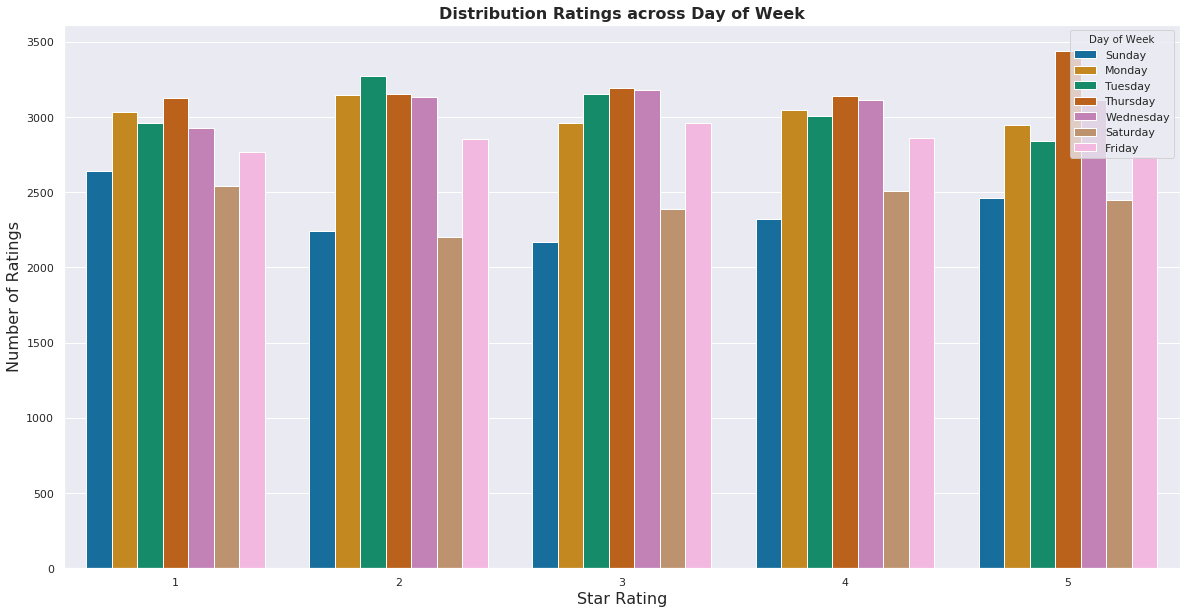

In [12]:
df = pd.DataFrame(data = {'Year':years, 'Month':months, 'Star Ratings':y, 'Weekday':weekdays})

df['Day of Week'] = converted_times.dt.day_name()


sns.set(palette='colorblind',style='darkgrid')
fig, ax = plt.subplots(figsize=(20,10))

sns.countplot(x="Star Ratings",
            hue='Day of Week', 
            data=df)

plt.title('Distribution Ratings across Day of Week', weight='bold', fontsize=16)
plt.xlabel('Star Rating', fontsize = 16)
plt.ylabel('Number of Ratings', fontsize = 16)

# Distribution of Review Length

In [0]:
def review_lengths(vectors):
   temp_list = []
   for review in vectors:
       temp_list.append(len(translate_review(review, reviews_dict)))
   return temp_list

length = review_lengths(reviews_bow)
#print(length)

length_list = np.zeros((11))
#print(length_list)

for index, x in enumerate(length):
    length_list[int(min(x,1000)/100)] +=1

In [14]:
print('Less than 100 Characters: ', length_list[0], '\nBetween 100 and 200 characters: ',length_list[1], '\nBetween 200 and 300 characters: ',length_list[2], '\nBetween 300 and 400 characters: ',length_list[3], 
      '\nBetween 400 and 500 characters: ',length_list[4], '\nBetween 500 and 600 characters: ',length_list[5], '\nBetween 600 and 700 characters: ',length_list[6], '\nBetween 700 and 800 characters: ',length_list[7], 
      '\nBetween 800 and 900 characters: ',length_list[8], '\nGreater than 1000 characters :',length_list[9])

print('\nMean Length Characers: ',mean(length))

Less than 100 Characters:  28330.0 
Between 100 and 200 characters:  30939.0 
Between 200 and 300 characters:  15730.0 
Between 300 and 400 characters:  8636.0 
Between 400 and 500 characters:  5136.0 
Between 500 and 600 characters:  3204.0 
Between 600 and 700 characters:  2121.0 
Between 700 and 800 characters:  1524.0 
Between 800 and 900 characters:  991.0 
Greater than 1000 characters : 754.0

Mean Length Characers:  254.5793


Text(0, 0.5, 'Count of Reviews')

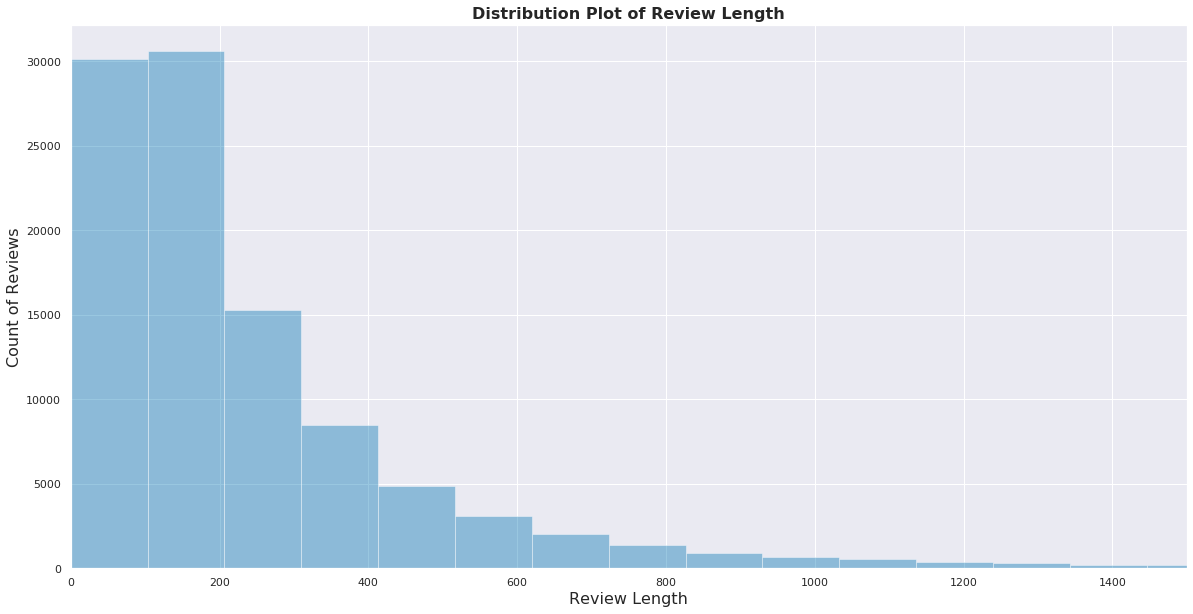

In [15]:
df = pd.DataFrame(data = {'Star Ratings':y, 'Review Length':length}).sort_values(by = ['Star Ratings','Review Length'])

sns.set(palette='colorblind',style='darkgrid')
fig, ax = plt.subplots(figsize=(20,10))
sns.distplot(length,
             bins = 150,
             kde = False,
             hist = True,
             color = 'b')
ax.set_xlim(0,1500)
plt.title('Distribution Plot of Review Length', weight='bold', fontsize=16)
plt.xlabel('Review Length', fontsize = 16)
plt.ylabel('Count of Reviews', fontsize = 16)

Most reviews are 100-300 characters, but the average amount of characters in a review is about 250 (there are some outlier reviews with 10,000+ characters!). Assuming that the average amount of characters in a paragraph is 254, reviewers typically write about half a paragraph.

#Review Length vs. Star Rating
Is there a difference between the length of a review and its corresponding star rating? 

Looks like there isn't a strong correlation between length of a review and it's rating. The ratings seem to be independent of length. 



Text(0, 0.5, 'Length of Review')

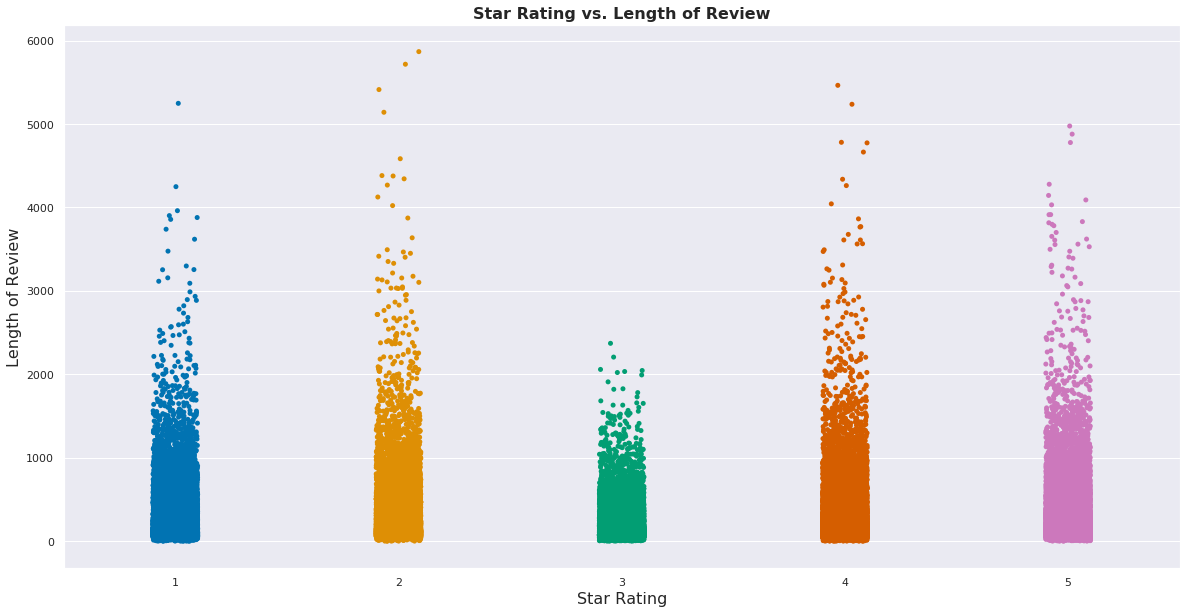

In [16]:
df = pd.DataFrame(data = {'Year':years, 'Month':months, 'Star Ratings':y, 'Weekday':weekdays, 'Review Length':length})
df = df[df['Review Length'] < 6000]
sns.set(palette='colorblind',style='darkgrid')
fig, ax = plt.subplots(figsize=(20,10))

'''sns.swarmplot(x="Star Ratings",
              y="Review Length",
              data=df)'''

sns.stripplot(x='Star Ratings',
              y = 'Review Length',
              data = df)

plt.title('Star Rating vs. Length of Review', weight='bold', fontsize=16)
plt.xlabel('Star Rating', fontsize = 16)
plt.ylabel('Length of Review', fontsize = 16)

# TDIF Weight Factored Word Cloud of Common Words for Stars 1-*5*
TF-IDF determines what words are most important for distinguishing the content of one document from another. It identifies the terms on which the document is most authoritative although there is no theoretical basis for this. 

The words that do come out, offer no help in our case as the words are stemmed and there is no real standout words that might make a difference in our modeling. The plots do serve as a nice visual to show what people are writing in the different segments of reviews.


In [0]:
def Convert(tup, di): 
    di = dict(tup) 
    return di 

def generate_wordclouds(review_list):
    from wordcloud import WordCloud
    a = lookup_docs(reviews_bow, review_list)
    tfidf = TfidfModel(a, normalize=True)
    weights = tfidf[a[0]]
    weights = [(reviews_dict[pair[0]], pair[1]) for pair in weights]
    #print(weights)

    wc = WordCloud(
    background_color="white",
    max_words=2000,
    width = 1024,
    height = 720,
    )

    weights = Convert(weights, weights)

    wc.generate_from_frequencies(weights)
    plt.figure(figsize = (20, 10), facecolor = None) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.imshow(wc) 
    plt.show(wc)

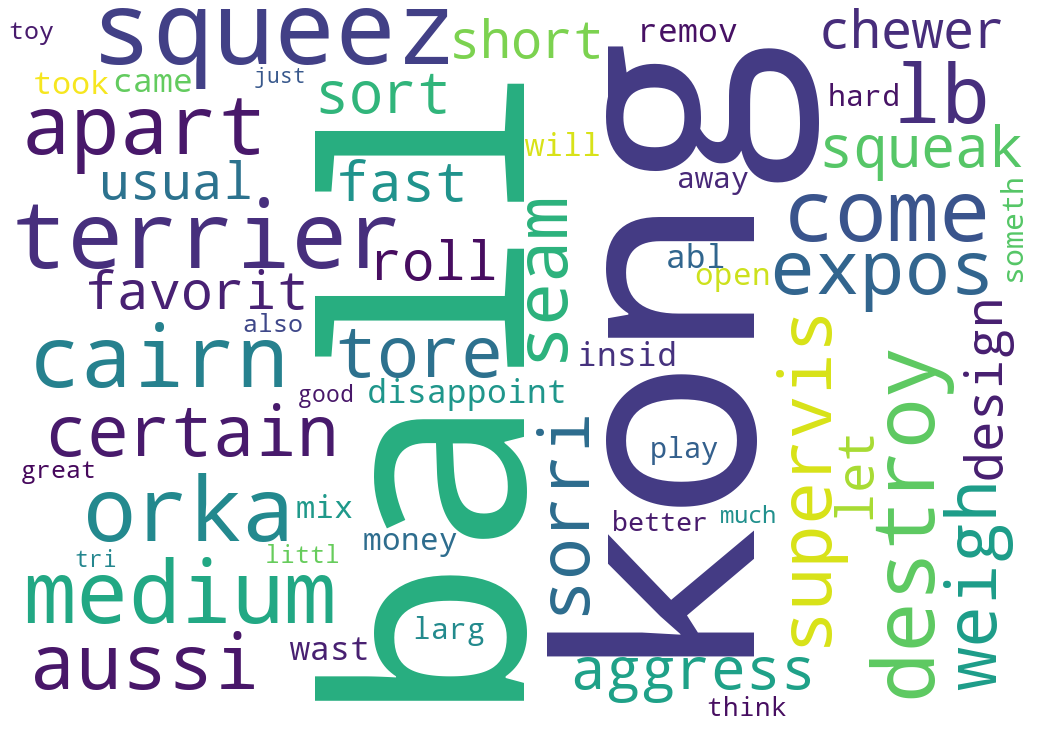

In [18]:
one_star_list = get_indices_for_star_rating(1)
generate_wordclouds(one_star_list)

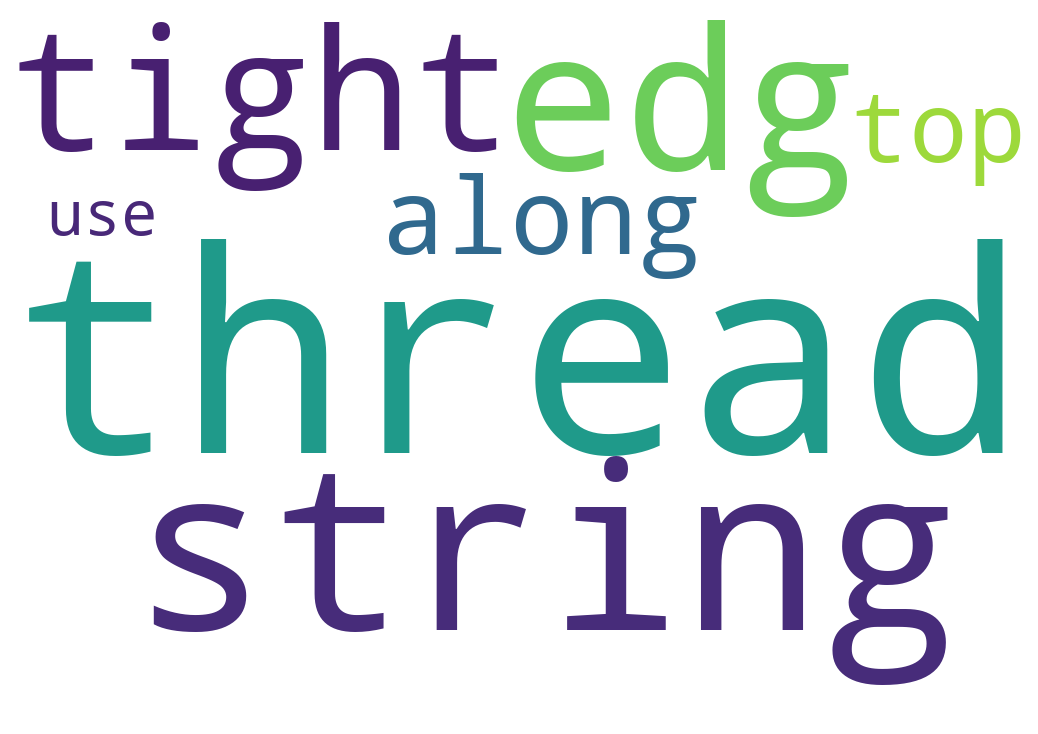

In [19]:
five_star_list = get_indices_for_star_rating(5)
generate_wordclouds(five_star_list)

# Make TD-IDF

In [0]:
def make_tfidf(reviews_bow):
    model = TfidfModel(reviews_bow, normalize=True)
    apply = model[reviews_bow]
    return apply

reviews_tfidf = make_tfidf(reviews_bow)

#Evaluating New Features on Random Forest Model
Even with the new features added there is no remarked change in the accuracy of the Random Forest Classifier. Comparing this with the another model, Logisitic Regression, we see that Random Forest is slightly better in accuracy. 

In [0]:
def extractDigits(lst): 
    return list(map(lambda el:[el], lst)) 

#converting to lists in order to add to original matrix as a feature
year = extractDigits(year)
month = extractDigits(months)
day = extractDigits(day)
weekdays = extractDigits(weekdays)
length_of_review = extractDigits(length)

def densify(sparse, columns):
    #initialize matrix in size of sparse matrix to 0s
    return_mat = list()
    for document in sparse:
        dense_doc = np.zeros(columns)
        #print(index)
        for element, count in document:
            #print(element, count)
            dense_doc[element] = count
            #print(dense_doc[element])
        return_mat.append(dense_doc)
    return np.array(return_mat)

In [0]:
#LSI on original matrix with new features added in
def generate_LSI_Model(X_orig, X_dict, X_times, y, num_topics):
    np.random.seed(1911)
    model = LsiModel(X_orig, id2word = X_dict, num_topics = num_topics)
    right_vecs = model[X_orig]
    v = densify(right_vecs, num_topics)
    r_f = evaluate_model(v, X_times, y)
    return r_f

#Random Forest Model
def evaluate_model(X, review_times, y):
    X = np.hstack((X, length_of_review, year, month, day, weekdays))
    X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state = 1911)
    rfor = RandomForestClassifier(n_estimators=70, random_state=1911)
    rfor.fit(X_train, y_train)
    
    accuracy = rfor.score(X_test, y_test)
    predictions = rfor.predict(X_test)
    cm = metrics.confusion_matrix(y_test, predictions)

    plt.figure(figsize=(20,10))
    sns.heatmap(cm, annot=True, fmt="0.0f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
    plt.title(all_sample_title, size = 15);
    return accuracy

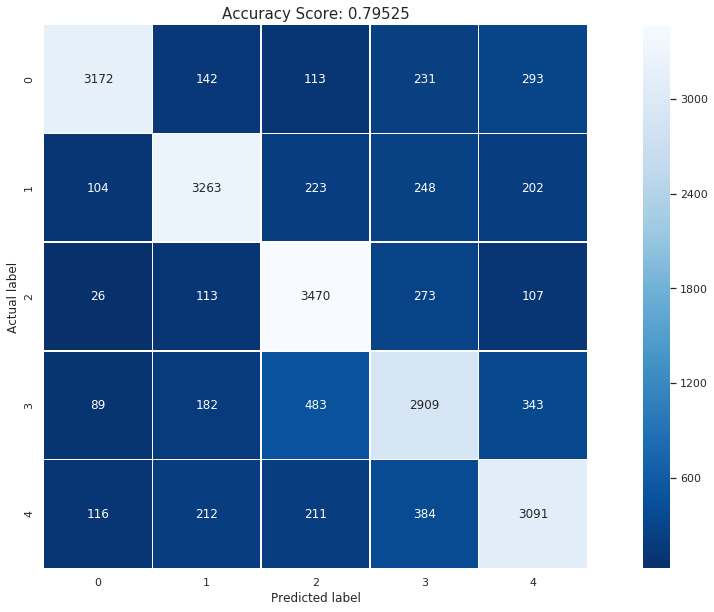

In [25]:
results = generate_LSI_Model(reviews_tfidf, reviews_dict, reviews_times, y, 40)

# Using Logistic Regression as a comparison

In [0]:
#LSI on original matrix with new features added in
def generate_LSI_Model(X_orig, X_dict, X_times, y, num_topics):
    np.random.seed(1911)
    model = LsiModel(X_orig, id2word = X_dict, num_topics = num_topics)
    right_vecs = model[X_orig]
    v = densify(right_vecs, num_topics)
    r_f = evaluate_model(v, X_times, y)
    return r_f

#Logistic Regression Model
def evaluate_model(X, review_times, y):
    X = np.hstack((X,length_of_review,year, month, day, weekdays))
    X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state = 1911)
    logisticRegr = LogisticRegression()
    logisticRegr.fit(X_train, y_train)
  
    accuracy = logisticRegr.score(X_test, y_test)
    predictions = logisticRegr.predict(X_test)

    cm = metrics.confusion_matrix(y_test, predictions)
    
    plt.figure(figsize=(20,10))
    sns.heatmap(cm, annot=True, fmt="0.0f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
    plt.title(all_sample_title, size = 15);
    return accuracy


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


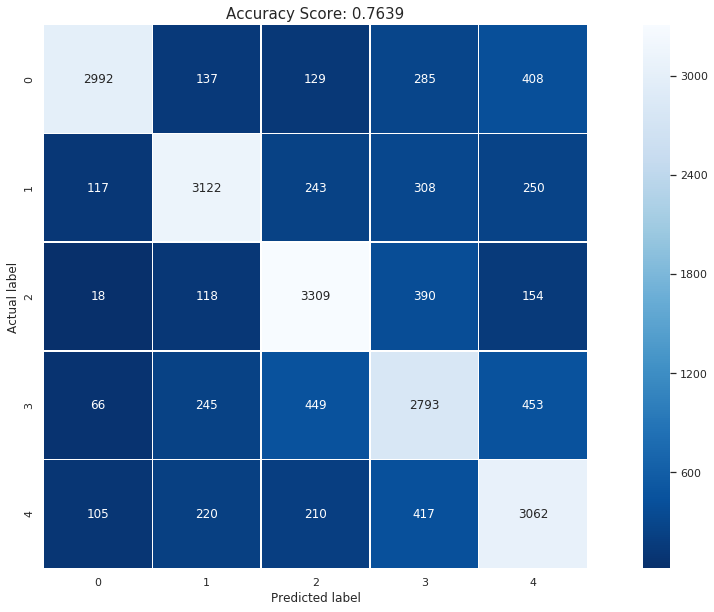

In [29]:
results = generate_LSI_Model(reviews_tfidf, reviews_dict, reviews_times, y, 40)

#Summary
Even after extracting all the new features from the dataset, I was unable to push the accuracy of the model past 80%. 
One thing I could try to possibly improve this would be to use boosting or ensembles to improve performane. Perhaps also trying a RNN might help with better accuracy results. Additionally having access to the whole dataset might have allowed for additional features that we could train the model on and perhaps get better results. 
